In [1]:
import comet_ml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

c:\Users\viren\miniconda3\envs\autogluon_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
comet_ml.init()
experiment = comet_ml.Experiment(project_name='juan-ai',
                                auto_histogram_weight_logging=True,
                                auto_histogram_gradient_logging=True,
                                auto_histogram_activation_logging=True)

experiment.set_name('mnist_gan')
experiment.add_tag('mnist')
experiment.add_tag('gan')


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wereign/juan-ai/c61c374e788645b3bad310a71860b4e2



In [3]:
CUDA = True
DATA_PATH = '../datasets/mnist_dataset'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 10
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 42


In [4]:
parameters = {"batch_size":128, "image_channel":1, "z_dim":100,"g_hidden":64,"x_dim":64,"d_hidden":64,"epoch_num":10,"lr":2e-4}
experiment.log_parameters(parameters=parameters)

In [5]:

CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.1.0+cu118
CUDA version: 11.8



In [6]:

# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

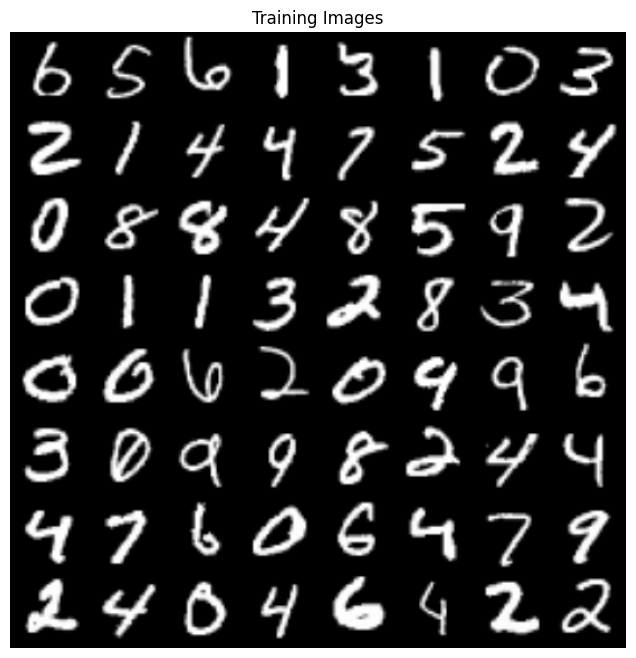

In [7]:

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    



In [10]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [11]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [13]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()


        experiment.log_metrics({
            "epoch":epoch,
            "discriminator_loss":errD.item(),
            "generator_loss":errG.item(), 
            "D_x":D_x, 
            "D_G_z1":D_G_z1, 
            "D_G_z2":D_G_z2})

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/469]	Loss_D: 2.1644	Loss_G: 5.5173	D(x): 0.7445	D(G(z)): 0.7707 / 0.0077
[0/10][50/469]	Loss_D: 0.0012	Loss_G: 32.2451	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[0/10][100/469]	Loss_D: 0.5920	Loss_G: 9.3227	D(x): 0.7261	D(G(z)): 0.0001 / 0.0005
[0/10][150/469]	Loss_D: 1.0153	Loss_G: 5.8189	D(x): 0.9990	D(G(z)): 0.5332 / 0.0113
[0/10][200/469]	Loss_D: 0.1051	Loss_G: 4.0607	D(x): 0.9418	D(G(z)): 0.0261 / 0.0262
[0/10][250/469]	Loss_D: 0.1394	Loss_G: 3.9431	D(x): 0.9389	D(G(z)): 0.0606 / 0.0317
[0/10][300/469]	Loss_D: 0.1649	Loss_G: 4.4096	D(x): 0.9513	D(G(z)): 0.1002 / 0.0191
[0/10][350/469]	Loss_D: 0.1626	Loss_G: 3.5473	D(x): 0.9127	D(G(z)): 0.0572 / 0.0417
[0/10][400/469]	Loss_D: 0.1207	Loss_G: 4.7193	D(x): 0.9794	D(G(z)): 0.0906 / 0.0142
[0/10][450/469]	Loss_D: 0.1671	Loss_G: 2.9489	D(x): 0.9095	D(G(z)): 0.0540 / 0.0768
[1/10][0/469]	Loss_D: 0.1897	Loss_G: 2.1011	D(x): 0.8665	D(G(z)): 0.0343 / 0.1583
[1/10][50/469]	Loss_D: 0.3128	Loss_G: 4.6331	D(x): 0.9

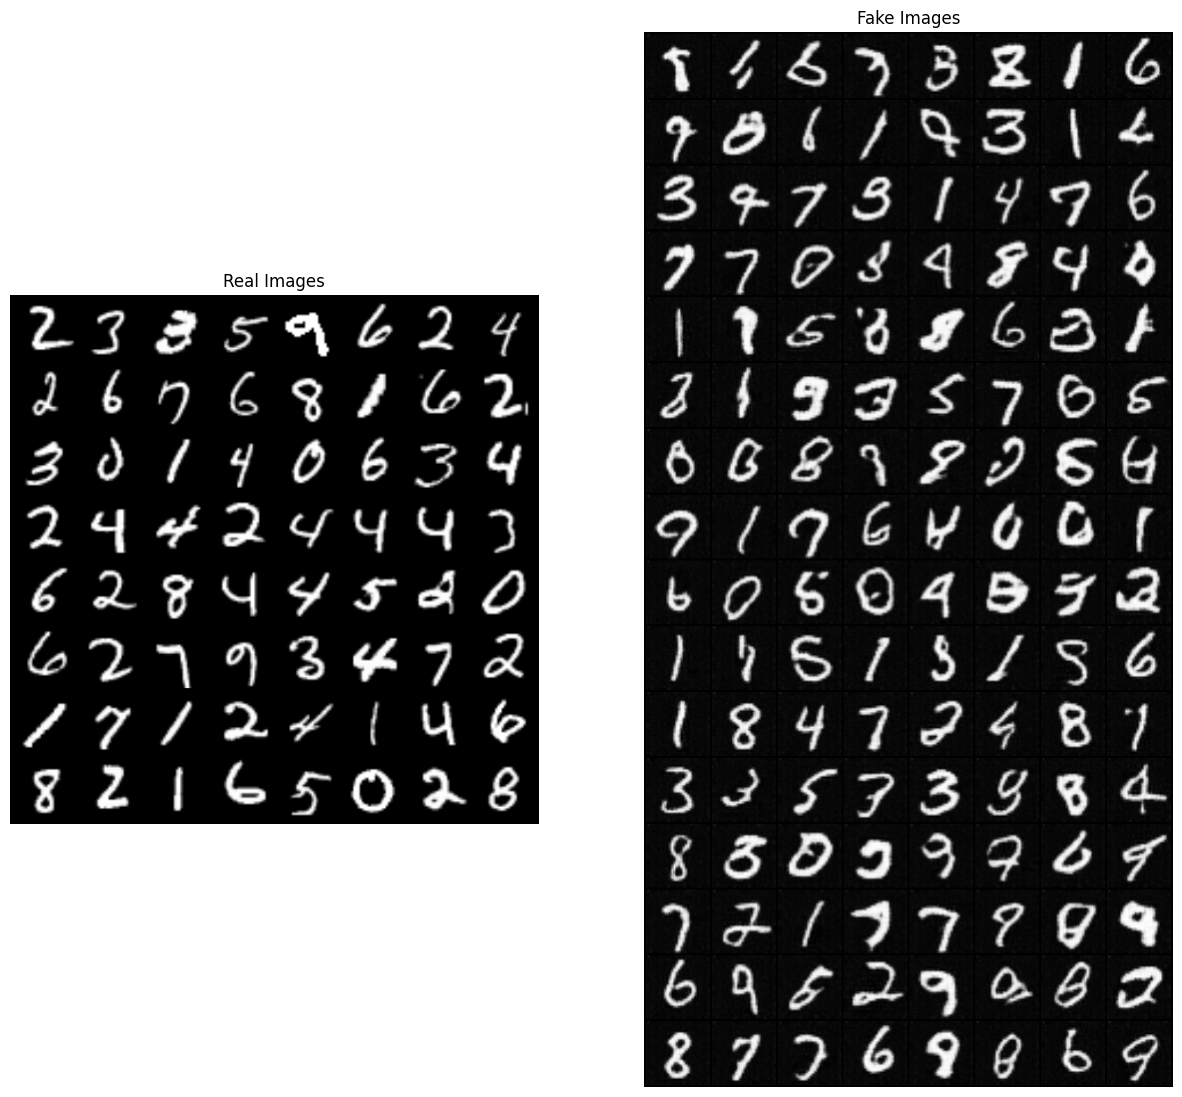

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

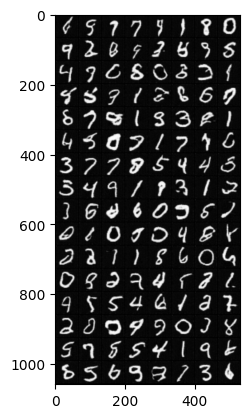

In [15]:
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
more_fake = netG(viz_noise).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(more_fake,normalize=True),(1,2,0)))

In [16]:
scripted_generator = torch.jit.script(netG)
torch.jit.save(scripted_generator,'../saved_models/generator.pt')

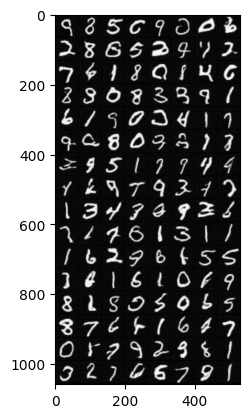

In [17]:
generator = torch.jit.load('../saved_models/generator.pt')
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
more_fake = generator(viz_noise).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(more_fake,normalize=True),(1,2,0)))


In [18]:
scripted_discriminator = torch.jit.script(netG)
torch.jit.save(scripted_discriminator,'../saved_models/discriminator.pt')

In [19]:
scripted_gan = torch.jit.script(netD)
torch.jit.save(scripted_discriminator,'../saved_models/discriminator.pt')

In [20]:
saved_dict = torch.save(netG,'../saved_models/generator_state_dict.pt')

In [21]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/wereign/juan-ai/c61c374e788645b3bad310a71860b4e2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     D_G_z1 [4690]             : (8.580614750462289e-16, 0.9990432262420654)
COMET INFO:     D_G_z2 [4690]             : (3.2069188837705964e-16, 0.9991455078125)
COMET INFO:     D_x [4690]                : (1.3821750144416e-07, 0.9999959468841553)
COMET INFO:     discriminator_loss [4690] : (4.212673957226798e-05, 17.108596801757812)
COMET INFO:     epoch [4690]              : (0, 9)
COMET INFO:     generator_loss [4690]     : (0.0008567771874368191, 36.139320373535156)
COMET INFO:     loss [1407]               : (2.02633896261